## Introduction ##

The telecom operator, Interconnect, would like to forecast churn of their clients.

**Problem Statement**: The company wants to forecast which users are planning to leave  
**Business Value**: To ensure loyalty, those who are going to leave will be offered with promotional codes and special plan options

Interconnect mainly provides two types of services:
1. Landline communication - the telephone can be connected to several lines simultaneously.
2. Internet - the network can be set up via a telephone line (*DSL*) or through a fiber optic cable. 

Other services the company provides include:
- Internet security via antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. The data is contained in the following files:
- *contract.csv:* contract information
- *personal.csv:* the client's personal data
- *internet.csv:* information about Internet services
- *phone.csv:* information about telephone services

In each file, the *customerId* column contains a unique code assigned to each client. The clients can choose either a monthly payment, or sign a 1 or 2-year contract. They can use various payment methods and receive an electronic invoice after the transaction. The contract information is valid as of February 1, 2020. 

Our goal is to develop a model that will classify the customers into two groups; loyal customers that will stay with Interconnect, and customers that will churn. The target is the *EndDate* column. Values with a date signifies the date the customer left, whereas a "No" means the client is active. The final model quality will be based on its AUC-ROC score ($\ge$ 0.88) and/or accuracy.

## Data Inspection and EDA ##

We'll first take an initial look at the dataset to better understand the items we'll need to address and develop a workplan.

**Loading the Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# When cloning this project, ensure directory/file paths are correct with respect to user's operating system
contract_df = pd.read_csv('datasets/final_provider/contract.csv')
internet_df = pd.read_csv('datasets/final_provider/internet.csv')
personal_df = pd.read_csv('datasets/final_provider/personal.csv')
phone_df = pd.read_csv('datasets/final_provider/phone.csv')

**Contract Data**

In [2]:
display(contract_df.sample(10))
contract_df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
911,7508-SMHXL,2018-11-01,No,Month-to-month,No,Credit card (automatic),89.00,1288.3
5578,8215-NGSPE,2016-08-01,No,Two year,No,Mailed check,20.00,833.55
5332,4565-EVZMJ,2016-03-01,No,One year,Yes,Mailed check,58.90,2813.05
5796,8571-ZCMCX,2016-03-01,No,Two year,Yes,Credit card (automatic),60.00,2768.65
3076,4250-FDVOU,2019-04-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,56.25,389.1
4551,5827-MWCZK,2015-06-01,No,Month-to-month,Yes,Credit card (automatic),96.95,5432.2
649,3509-GWQGF,2018-02-01,No,Month-to-month,No,Credit card (automatic),70.00,1732.6
4856,8714-EUHJO,2017-05-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,91.15,2995.45
495,8205-OTCHB,2018-01-01,2019-11-01 00:00:00,One year,Yes,Bank transfer (automatic),43.75,903.6
3216,7250-EQKIY,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Mailed check,50.45,50.45


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


The main dataset has 7,043 entries with no missing values. In order to facilitate our analysis, we'll convert some of the datatypes to something more appropriate. The monthly and total charges will be converted to floating point numbers. In order to mitigate new accounts that have no historical charges accrued (i.e. total charges), we'll set the errors parameter to *coerce* and convert NaN values to 0. Additonally, we'll convert account start dates to datetime objects.

In [3]:
contract_df['MonthlyCharges'] = pd.to_numeric(contract_df['MonthlyCharges'], errors='coerce')
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')
contract_df['TotalCharges'] = contract_df['TotalCharges'].replace(np.NaN, 0.)
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')

contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


We'll subdivide the data for our contract analysis into active customers and inactive (churned) customers. Something we'll need to consider when training the models is we'll want to convert the values in the end date column that is better suited for a classification task. We'll also add a column, *ContractLength*, to examine the distribution of time former clients spent with Interconnect.

In [4]:
inactive_customers = contract_df[contract_df['EndDate'] != 'No'].copy()
active_customers = contract_df[contract_df['EndDate'] == 'No'].copy()

inactive_customers['EndDate'] = pd.to_datetime(inactive_customers['EndDate'], format='%Y-%m-%d')
inactive_customers['ContractLength'] = (inactive_customers['EndDate'] - inactive_customers['BeginDate']).dt.days.astype('int')

active_customers.info()
inactive_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        5174 non-null   object        
 1   BeginDate         5174 non-null   datetime64[ns]
 2   EndDate           5174 non-null   object        
 3   Type              5174 non-null   object        
 4   PaperlessBilling  5174 non-null   object        
 5   PaymentMethod     5174 non-null   object        
 6   MonthlyCharges    5174 non-null   float64       
 7   TotalCharges      5174 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 363.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 2 to 7041
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        1869 non-null   object        
 1   BeginDat

In [5]:
display(contract_df['BeginDate'].sort_values(ascending=True).head(1))
display(contract_df['BeginDate'].sort_values(ascending=False).head(1))

print('Active customers: ', (contract_df['EndDate'] == 'No').sum())
print('Inactive customers: ', (contract_df['EndDate'] != 'No').sum())

4513   2013-10-01
Name: BeginDate, dtype: datetime64[ns]

6670   2020-02-01
Name: BeginDate, dtype: datetime64[ns]

Active customers:  5174
Inactive customers:  1869


The account start dates range from October 2013 to February 2020 (i.e. the end of the dataset). The ratio of active customers to inactive customers is approximately 2.5:1. The overall number of observations is relatively small and it appears there may be a slight class imbalance; an option we should explore during model training is to incorporate upscaling to mitigate imbalance issues.

We'll define the fuction, *plot_data( )*, to visualize the contract data.

**Paramaters**:
- column: String object of the column name to plot.
- active: DataFrame slice of active customers, default value of None.
- inactive: DataFrame slice of inactive customers, default value of None.

**Returns**: Nothing. Prints the first and last five observations for the given column(s), aggregate calculations, and displays a boxplot and normalized histogram of the provided dataset(s).

In [6]:
def plot_data(column, active=None, inactive=None):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 
    
    if column == 'ContractLength':
        print(inactive[column].sort_values(ascending=True).head(5))
        print(inactive[column].sort_values(ascending=True).tail(5))
        print(inactive[column].describe())

        fig.suptitle('Contract Length for Inactive Customers')
     
        ax = axs[0]
        ax.boxplot(inactive[column])
        ax.set_title('Length of Term')
        ax.set_ylabel('Days')
        ax.set_xlabel('Churned Customers')

        ax = axs[1]
        ax.hist(inactive[column])
        ax.set_title('Distribution of Term Length')
        ax.set_xlabel('Days')
        ax.set_ylabel('Number of Customers')
    else:
        print(contract_df[column].sort_values(ascending=True).head(5))
        print(contract_df[column].sort_values(ascending=True).tail(5))
        print('Active: ', active[column].describe())
        print('Inctive: ', inactive[column].describe())

        ax = axs[0]
        ax.boxplot((active[column], inactive[column]))
        ax.set_title('Amount Spent')
        ax.set_ylabel('Dollars')
        ax.set_xticks((1, 2))
        ax.set_xticklabels(('Active', 'Inactive'))
        ax.set_xlabel('Customers')
               
        ax = axs[1]
        ax.hist(active[column], bins=30, density=True)
        ax.hist(inactive[column], bins=30, density=True, alpha=0.6)
        ax.set_title('Normalized Distribution of Charges')
        ax.set_xlabel('Amount Spent (USD)')
        ax.set_ylabel('% of Customers')
        ax.legend(['Active Customers', 'Inactive Customers'])

        if column == 'MonthlyCharges':
            fig.suptitle('Monthly Charges')
        else:
            fig.suptitle('Total Charges')      

    plt.show()    
    
    return

837     30
2269    30
4706    30
6317    30
5100    30
Name: ContractLength, dtype: int32
4513    2191
3439    2191
3111    2191
4610    2191
3890    2191
Name: ContractLength, dtype: int32
count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: ContractLength, dtype: float64


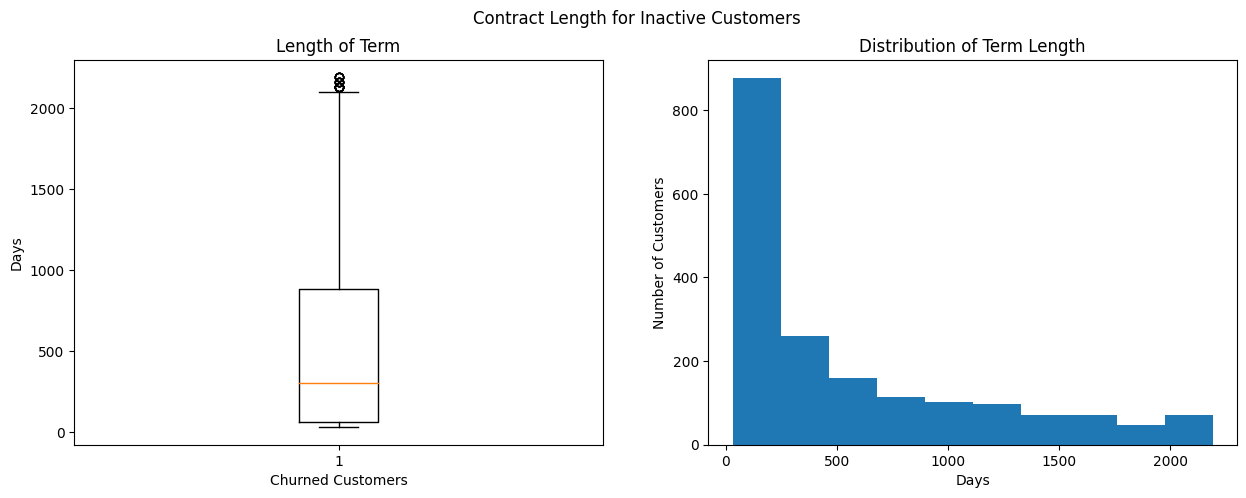

In [7]:
plot_data('ContractLength', inactive=inactive_customers)

From the aggregate calcualtions and plots, we can see that most of the churned customers stayed with with Interconnect for less than three years. The minimum term was one month and the maximum term was 2191 days (about 6 years). On average, customers left Interconnect after about one and half years with the median term length of about 10 months.

3719    18.25
1529    18.40
6652    18.55
6906    18.70
1156    18.70
Name: MonthlyCharges, dtype: float64
5127    118.35
3894    118.60
4804    118.60
2115    118.65
4586    118.75
Name: MonthlyCharges, dtype: float64
Active:  count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64
Inctive:  count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64


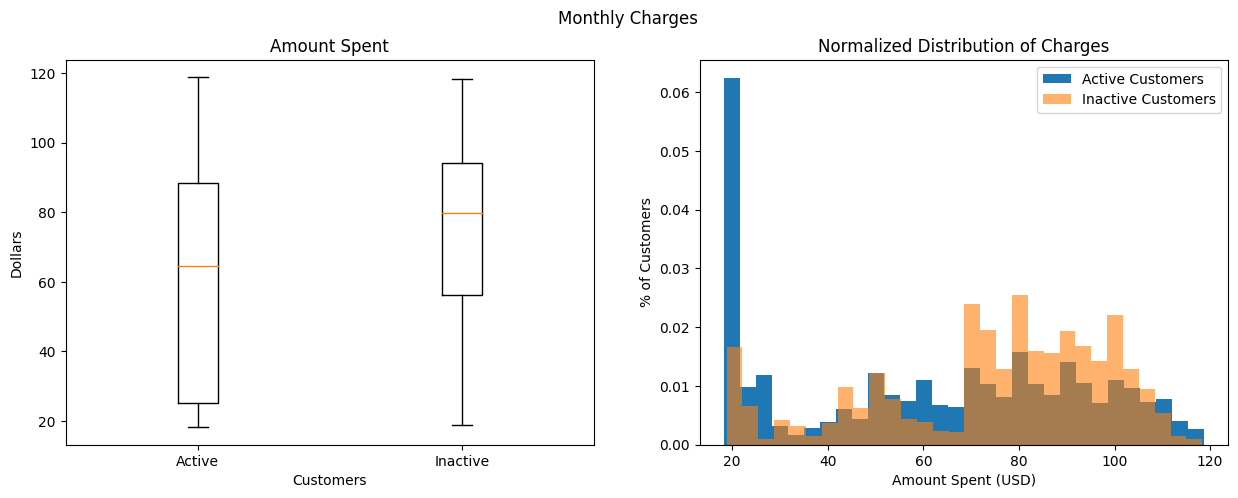

In [8]:
plot_data('MonthlyCharges', active=active_customers, inactive=inactive_customers)

It appears most of the churned customers had higher monthly costs than active customers. We can see churned customers had a higher average and median monthly cost than customers that stayed with Interconnect. The distribution of monthly costs between the two groups appear similar, but the histgram shows a higher percentage of churned customers did have higher monthly costs when compared to active customers.

3826    0.0
5218    0.0
4380    0.0
753     0.0
488     0.0
Name: TotalCharges, dtype: float64
2187    8564.75
5347    8594.40
6768    8670.10
4586    8672.45
4610    8684.80
Name: TotalCharges, dtype: float64
Active:  count    5174.000000
mean     2549.911442
std      2329.954215
min         0.000000
25%       572.900000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: TotalCharges, dtype: float64
Inctive:  count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: TotalCharges, dtype: float64


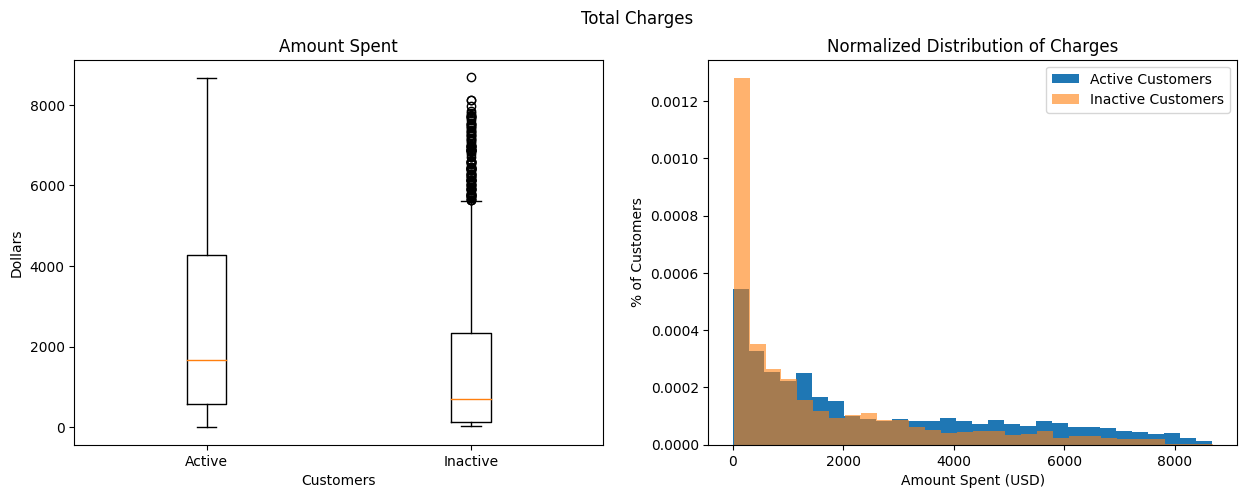

In [9]:
plot_data('TotalCharges', active_customers, inactive_customers)

When comparing the groups in terms of total costs, it appears churned custoemrs had overall lower total costs. This is likely due to fact that they terminated their contracts with Interconnect, thus stopping additonal spending history.

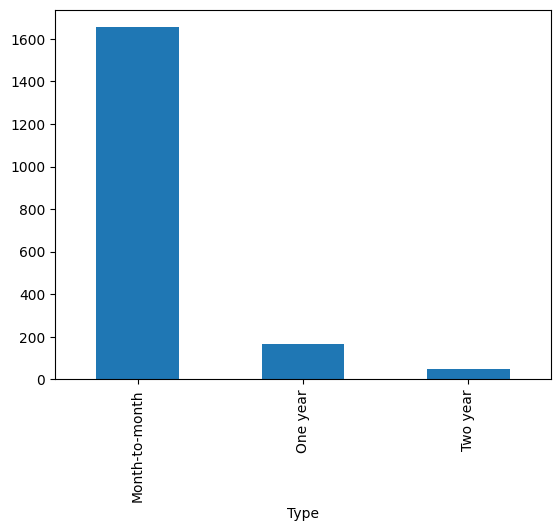

In [10]:
inactive_customers.groupby('Type')['Type'].count().plot(kind='bar')
plt.show()

Lastly, we can see the plan type chosen by the majority of churned customers was month-to-month.

**Internet Data**

In [11]:
display(internet_df.sample(10))
internet_df.info()
print(internet_df.nunique())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1205,1921-KYSAY,DSL,No,No,Yes,Yes,No,Yes
1519,4587-NUKOX,Fiber optic,Yes,Yes,No,No,No,No
4177,3370-GQEAL,Fiber optic,No,No,No,No,Yes,No
5012,2486-WYVVE,DSL,No,No,Yes,Yes,Yes,Yes
3113,4778-IZARL,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
1454,3537-RYBHH,DSL,Yes,Yes,Yes,No,No,No
2427,7271-AJDTL,Fiber optic,No,Yes,Yes,No,Yes,No
47,7495-OOKFY,Fiber optic,No,Yes,No,No,No,No
2391,0263-FJTQO,DSL,Yes,No,No,Yes,Yes,No
1685,3023-GFLBR,Fiber optic,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64


The internet dataset has 5,517 observations. This implies not every customer had an internet subscription. Per the project description, the features are essentially binary values although represented as String objects, presently. When training the model, we'll likely merge this dataset (and the other ancillary datasets) with the main contract data, and then encode the features.

Similar to the function above, we'll use a function to facilitate data visualization of the follow-on data. The function, *hist_grid( )*, is defined as follows:

**Parameters**:
- df: DataFrame object of the data used for plotting

**Returns**: Nothing. Plots histograms of the different data columns from the DataFrame into a grid.

In [12]:
def hist_grid(df):
    columns = df.drop('customerID', axis=1).columns
    size = round(len(columns)/2)
    row = 0
    col = 0
    counter = 0

    fig, axs = plt.subplots(2, size, figsize=(15, 8)) 

    for name in columns:
        ax = axs[row, col]
        ax.hist(df[name])
        ax.set_title(name)
    
        counter += 1
        col = counter % size
        if counter == size:
            row += 1

    if len(columns) < size * 2:
        axs[row, col].axis('off')    
        
    plt.show()

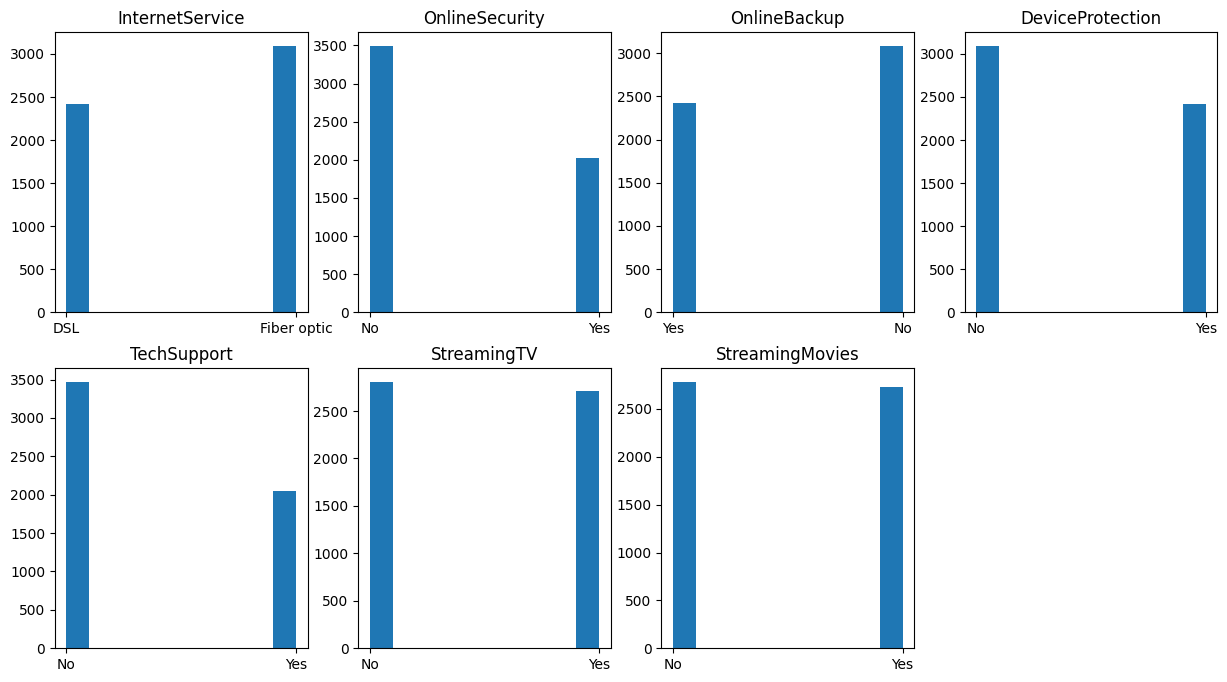

In [13]:
hist_grid(internet_df)

Nothing extraordinary here. There is about an even split of customers that had various streaming service, but most customers opted out on the other service subscriptions.

**Personal Data**

In [14]:
display(personal_df.sample(10))
personal_df.info()
print(personal_df.nunique())

,customerID,gender,SeniorCitizen,Partner,Dependents
4637,9470-YFUYI,Male,1,Yes,No
2062,7996-MHXLW,Female,0,No,No
423,3935-TBRZZ,Male,0,Yes,Yes
5942,7240-ETPTR,Female,0,Yes,No
5993,2080-GKCWQ,Male,0,No,No
1227,8496-DMZUK,Male,0,No,No
3730,6771-XWBDM,Female,0,Yes,No
392,0224-RLWWD,Female,1,No,No
517,6705-LXORM,Female,1,Yes,No
1836,6365-MTGZX,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64


The personal data holds the demographic information for all of the customers. These features will also need to be encoded if used for model training.

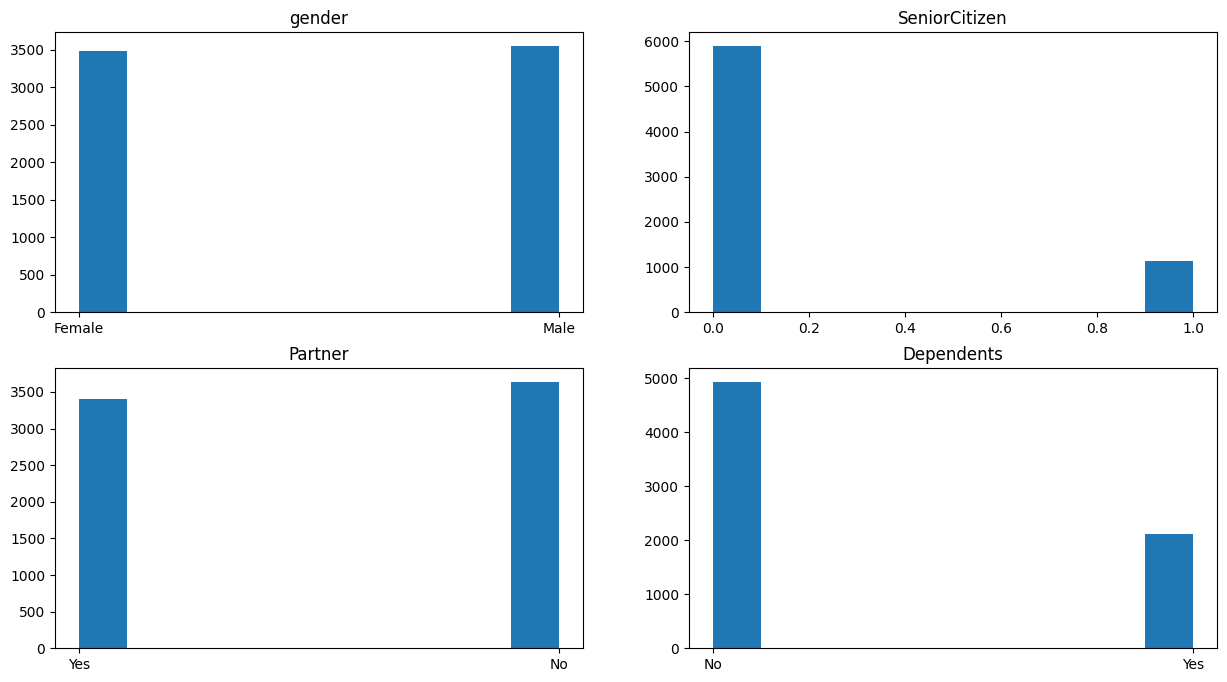

In [15]:
hist_grid(personal_df)

Visualizing the personal data, we see there is about an even amount of male and female customers, as well as those with and without a partner. Furthermore, there are less customers that qualify as senior citizens, or have dependents.

**Phone Data**

In [16]:
display(phone_df.sample(10))
phone_df.info()
print(phone_df.nunique())

,customerID,MultipleLines
590,5845-BZZIB,No
418,4640-UHDOS,No
2518,9534-NSXEM,No
6097,1960-UOTYM,No
3294,9544-PYPSJ,Yes
1462,7941-RCJOW,No
5456,2325-NBPZG,No
572,7665-VIGUD,No
708,7521-AFHAB,No
3727,5055-BRMNE,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
customerID       6361
MultipleLines       2
dtype: int64


There are 6,361 customers that had phone lines. Based on the number of observations, we can infer that some of these customers also had internet service(s) subscriptions.

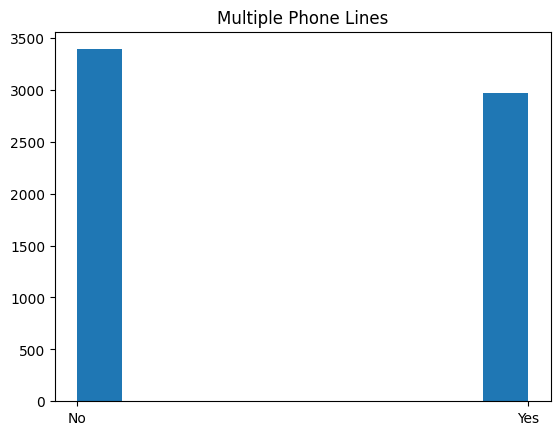

In [17]:
phone_df['MultipleLines'].hist(grid=False)
plt.title('Multiple Phone Lines')
plt.show()

Based on the values, we can see there were slightly more customers that had only a single phone line.

## Inspection Summary ##

The information spans from October 2013 to February 2020. There are 7,043 unique customers in the dataset, some of which that had internet, phone line(s), or both. Generally, churned customers had higher monthly charges than active customers, and most inactive customers terminated their contracts within three years. For this classification task, there exists a class imbalance (i.e. churn date) which we will address using upscaling, or another appropriate technique.

The integrity of the data appears to be in good order for the most part, but we'll need to address some of the datatypes (i.e. target feature, internet subscriptions, etc.) when we merge the data and encode the features. Something to consider when we merge the datasets is that we'll create empty/NaN values in certain columns (e.g. customers that did not subscribe to both phone and internet services). We'll fill the empty values appropriately and train the model according to the following work plan.

## Work Plan ##

1. **Load and process the data.** We'll load the data and recast the datatypes as necessary to facilitate feature encoding/engineering. One of the specific columns that will need to be adjusted is the target column (*EndDate*). As this is a binary classification task, we'll ensure the column is set to appropriate numerical values (e.g. 1 for churned, 0 for active).

2. **Merge the datasets.** The contract data will be our main dataset, but we'll look to merge the other sets so we can incorporate those features into our model training. We'll conduct a full outer merge on the *customerID* column to ensure none of the information is lost. As such, we'll likely generate instances of NaN values that will need to be replaced with suitable values.

3. **Feature selection/engineering.** Once the dataset has been merged and cleaned, we'll select our target and features. Most of the features we'll use are categorical, thus we'll incorporate one-hot encoding (OHE) when appropriate (i.e. some models, such as CatBooost, used in training will handle categorical features explicitly). Since the size of the dataset is relatively small, we'll upscale certain observations to address any class imbalance issues.

4. **Splitting the data.** We'll split the data into training and test sets using a 3:1 ratio. We'll ensure features are encoded prior to the split (for models that require OHE) to mitigate losing potential features during validation.

5. **Model training and evaluation.** For this classification task, we'll train and tune a variety of models. Specially, we'll train and evaluate the following:
    - DummyClassifier (to serve as a baseline sanity check)
    - LogisticRegression
    - DecisionTreeClassifier
    - RandomForestClassifier
    - LightGBM
    - CatBoost

    We'll look to train and evaluate the models using a cross-validation method on the training set, and adjust a variety of hyperparameters to improve model quality. The primary metric used for evaluation will be the model's AUC-ROC score, but we'll also monitor their accuracy scores. Things we'll need to address before passing data to model training are class imbalancing and data normalization. The best estimator for each model (i.e. parameters yielding best cv score(s)) will then be evaluated against the validation set.

6. **Model selection.** We'll compare the validation scores among the models and identify the top performer. Our goal is to achieve an AUC-ROC score of 0.88.

## Amplifying Remarks ##

Depending on runtime performance, student may elect to only train the DummyClassifier, LogisticRegression, RandomForestClassifier, and CatBoost models. Student has no additional questions, but any assistance or advice is welcome.